<a href="https://colab.research.google.com/github/KhoomeiK/MindMapResearch/blob/master/HAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DATA PREP STUFF

In [0]:
# download dataset and labels
! pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded2 = drive.CreateFile({'id': '1HvZH9ys_ufTF-wcRMNFSKS7lT3pJu6YY'}) 
downloaded2.GetContentFile('labels.pkl')

downloaded = drive.CreateFile({'id': '1BqSv5mgxsyP5rhMoAAKFyvPtAH8XLcO6'}) 
downloaded.GetContentFile('embeddings.zip')

! unzip embeddings.zip

In [0]:
# read dataset into memory
from os import listdir
from os.path import isfile, join
import pandas as pd

mypath = 'cse198f_shiv'
csvs = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(len(csvs))

data = []
names = []
for csv in csvs:
    if csv[-4:] == '.csv':
        try:
            data.append(pd.read_csv(join(mypath, csv), encoding='CP1252'))
            names.append(csv[:-4])
        except:
            try:
                data.append(pd.read_csv(join(mypath, csv), encoding='UTF8'))
                names.append(csv[:-4])
            except:
                continue
print(len(data))

# pd.reset_option('all')
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)

In [0]:
# # download embedding tools
# ! ls *
# ! mkdir fastText
# ! curl https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip > fastText/crawl-300d-2M.vec.zip
# ! unzip fastText/crawl-300d-2M.vec.zip -d fastText/
# ! mkdir encoder
# ! curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl
# ! curl https://raw.githubusercontent.com/facebookresearch/InferSent/master/models.py > models.py
# ! mkdir embeddings

In [0]:
# generate embeddings of dataset
import torch, os
import numpy as np
import tensorflow_hub as hub

from absl import logging
from models import InferSent

import pickle
import time

MODEL_PATH = 'encoder/infersent2.pkl'
W2V_PATH = 'fastText/crawl-300d-2M.vec'

def load_infersent_model(model_path=MODEL_PATH, word_embeddings_path=W2V_PATH):
	params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048, 'pool_type': 'max', 'dpout_model': 0.0, 'version': 2}
	infersent = InferSent(params_model).cuda()
	infersent.load_state_dict(torch.load(model_path))
	infersent.set_w2v_path(word_embeddings_path)
	infersent.build_vocab_k_words(K=100000)
	return infersent

def get_infersent_vectors(sentences, model):
	return model.encode(sentences, tokenize=False, verbose=False)

def get_user_data_embeddings(comments, model):
	# model = load_infersent_model()
	embedding = get_infersent_vectors(comments, model)
	return embedding

dataEmbeddings = []
model = load_infersent_model()

start = time.time()
for i, name in enumerate(names):
	comments = list(data[i]['text']) if 'text' in data[i] else []
	if len(comments) >= 1:
		print(i, name)
		try:
			embeddings = get_user_data_embeddings(data[i]['text'], model)
			print(len(embeddings), 'comments')
			dataEmbeddings.append(embeddings)
			with open('embeddings/%s.pkl' % name, 'wb') as pkl:
				pickle.dump(embeddings, pkl)
		except:
			print('ERROR')

print(time.time() - start)

## MODEL RUN

In [0]:
# load labels and user embeddings and create Users data obj
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from csv import reader
import pickle
from os import listdir
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Users(Dataset):
    def __init__(self, embedPath, labelPath): 
        self.users, self.labels = [], []
        users = {}
        labels = pickle.load(open(labelPath, 'rb')) # { username: [ depressionPercent, vaderScore ] }
        fileList = listdir(embedPath)

        for user in fileList: # must download and unzip embeddings.zip first
            users[user[:-4]] = pickle.load(open('%s/%s' % (embedPath, user), 'rb'))

        intersection = list(set(users.keys()).intersection(set(labels.keys())))
        for i in intersection:
            userTensor = torch.tensor([users[i]])
            if list(userTensor.shape)[1] != 1: # exclude single comment users
                self.users.append(userTensor)
                self.labels.append(torch.tensor([labels[i][0]]))

        print(len(self), self[0])

    def __getitem__(self, i):
        return self.users[i], self.labels[i] # change to include others
    
    def __len__(self):
        assert len(self.users) == len(self.labels)
        return len(self.users)

# def my_collate(batch):
#     data = [item[0] for item in batch]
#     target = [item[1] for item in batch]
#     target = torch.Tensor(target)
#     return [data, target]

train, valid, test = random_split(Users('user_subset', 'labels.pkl'), [4280, 538, 538])

# dataloader_params = {'batch_size': 4, 'shuffle': True, 'collate_fn': my_collate}
# train, test = DataLoader(train, **dataloader_params), DataLoader(test, **dataloader_params)

In [0]:
def matrix_mul(input, weight, bias=False):
    feature_list = []
    for feature in input.squeeze(0):
        feature = torch.mm(feature.unsqueeze(0), weight)
        if isinstance(bias, torch.nn.parameter.Parameter):
            feature = feature + bias.expand(feature.size()[0], bias.size()[1])
        feature = torch.tanh(feature)#.unsqueeze(0) ?
        feature_list.append(feature)

    return torch.cat(feature_list, 0)#.squeeze(1) ?

def element_wise_mul(input1, input2):
    feature_list = []
    for feature_1, feature_2 in zip(input1.squeeze(0), input2):
        feature = feature_1 * feature_2
        feature_list.append(feature.unsqueeze(0))

    output = torch.cat(feature_list, 0)
    return torch.sum(output, 0).unsqueeze(0)

class AN(nn.Module):
    def __init__(
        self,
        # batch_size=4,
        embedding_dimension=4096, 
        hidden_size=128, 
        # n_layers=1, # multiple?
    ):
        super(AN, self).__init__()
        # self.n_layers = n_layers
        self.hidden_size = hidden_size
        # self.batch_size = batch_size

        self.sent_weight = nn.Parameter(torch.randn(2 * hidden_size, 2 * hidden_size))
        self.sent_bias = nn.Parameter(torch.randn(1, 2 * hidden_size))
        self.context_weight = nn.Parameter(torch.randn(2 * hidden_size, 1))

        self.gru = nn.GRU(embedding_dimension, hidden_size, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, 1) 
        self._create_weights(mean=0.005)

    def _create_weights(self, mean=0.0, std=0.01):
        self.sent_weight.data.normal_(mean, std)
        self.sent_bias.data.normal_(mean, std)
        self.context_weight.data.normal_(mean, std)

    def forward(self, user):
        f_output, h_output = self.gru(user)
        output = matrix_mul(f_output, self.sent_weight, self.sent_bias)
        output = F.dropout(output)
        output = matrix_mul(output, self.context_weight)#.permute(1, 0) ?
        output = F.softmax(output)
        output = element_wise_mul(f_output, output).squeeze(0) # '''output.permute(1, 0) ?'''
        output = self.fc(output)
        output = F.sigmoid(output)

        return output #, h_output

class Simple(nn.Module):
    def __init__(
        self,
        embedding_dimension=4096,
        hidden_size=128, 
    ):
        super(Simple, self).__init__()

        self.gru = nn.GRU(embedding_dimension, hidden_size, bidirectional=True)
        self.fc = nn.Linear(4 * hidden_size, 1) 

    def forward(self, user):
        f_output, h_output = self.gru(user)
        output = torch.cat([f_output[0][0], f_output[0][-1]], dim=0) # concat start and end
        output = F.dropout(output)
        output = self.fc(output)
        output = F.sigmoid(output)

        return output #, h_output

In [0]:
hidden = 128
learning = 0.001
epochs = 4
model = AN(hidden_size=hidden).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning)
criterion = nn.MSELoss()
model.train()

train_losses, valid_losses = [], []

for epoch in range(epochs):
    print('TRAIN', epoch)
    train_loss, total = 0, 0
    for X, Y in train:
        # loss = 0
        # X, Y = [x.unsqueeze(0).to(device) for x in X], [y.to(device) for y in Y]
        # for x, y in zip(X, Y):
        #     pred = model(x)
        #     # print(pred, y)
        #     if loss == 0:
        #         loss = criterion(pred, y)
        #     else:
        #         loss += criterion(pred, y)
        # loss /= 4
        X, Y = X.to(device), Y.to(device)
        pred = model(X)
        loss = criterion(pred, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total += 1

        if total % 300 == 0:
            print(pred.item(), Y.item(), loss.item())

    train_losses.append(train_loss / total)
    print('TRAIN:', epoch, train_losses[-1])

    with torch.no_grad():
        print('VALIDATION', epoch)
        valid_loss, valid_total = 0, 0
        for X, Y in valid:
            X, Y = X.to(device), Y.to(device)
            pred = model(X)
            loss = criterion(pred, Y)

            valid_loss += loss.item()
            valid_total += 1
            
            if valid_total % 100 == 0:
                print(pred.item(), Y.item(), loss.item())
        
        valid_losses.append(valid_loss / valid_total)
        print('VALID:', epoch, valid_losses[-1])

print(train_losses)
print(valid_losses)

TRAIN 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


7.290000919005397e-15 0.0 5.314411088542139e-29
0.0 0.0 0.0
0.0 0.03999999910593033 0.0015999999595806003
0.0 0.0 0.0
0.0 0.0 0.0
2.3008792910876796e-20 0.0 5.294049546280586e-40
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
3.242496424742328e-27 0.0 0.0
0.00012832105858251452 0.032258063554763794 0.0010323203168809414
1.4211182479428157e-23 0.0555555559694767 0.003086419776082039
3.085779826506041e-05 0.0 9.52203760284931e-10
0.09287744015455246 0.23999999463558197 0.02164504863321781
TRAIN: 0 0.06087874248133393
VALIDATION 0
1.1616422613321825e-13 0.029999999329447746 0.0008999999845400453
0.00014598433335777372 0.0 2.1311425513204085e-08
0.00017733631830196828 0.0 3.1448170290104827e-08
0.001574213500134647 0.0 2.478148189766216e-06
0.508177638053894 0.5 6.687376298941672e-05
VALID: 0 0.03343691977139501
TRAIN 1
0.19935928285121918 0.0 0.03974412381649017
0.0006119865574873984 0.0 3.745275591882091e-07
5.004243575967848e-06 0.03999999910593033 0.0015995997237041593
3.5156234824687744e-16 0.0 

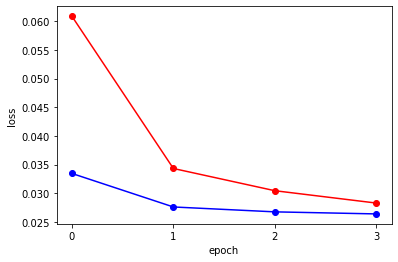

In [0]:
from matplotlib import pyplot as plt

plt.xticks(range(len(train_losses)))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_losses, '-ro')
plt.plot(valid_losses, '-bo')

# torch.save(model.state_dict(), 'model_save.pkl')
# upload = drive.CreateFile({'title': 'model_save_5-8-20.pkl'}) # change name
# upload.SetContentFile('model_save.pkl')
# upload.Upload()

In [0]:
torch.no_grad()
total = 0
test_losses = []
preds = []

for X, Y in test:
    # X, Y = [x.unsqueeze(0).to(device) for x in X], [y.to(device) for y in Y]
    # for x, y in zip(X, Y):
    #     pred = model(x)
    #     loss = criterion(pred, y)
        
    #     # print('pred', pred.item())
    #     # print('targ', y.item())
    #     # print('loss', loss.item())
        
    #     total += 1
    #     losses.append(loss.item())

    X, Y = X.to(device), Y.to(device)
    pred = model(X)
    loss = criterion(pred, Y)

    preds.append(pred)
    test_losses.append(loss.item())
    total += 1
    
    if total % 100 == 0:
        print(pred.item(), Y.item(), loss.item())

test_loss = sum(test_losses) / total
print(test_loss)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1.187813058255095e-18 0.0 1.4108998475115147e-36
2.2047202718926004e-21 0.0 4.8611043727427904e-42
0.1978142261505127 0.0 0.03913046792149544
0.6186259984970093 1.0 0.14544612169265747
8.536010982253261e-13 0.0 7.286348263738479e-25
0.030399615179059477


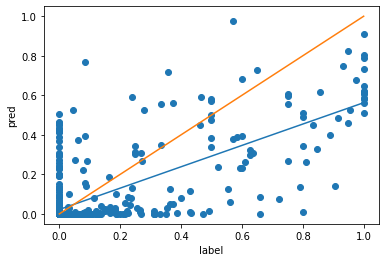

In [0]:
import numpy as np
# preds = [pred.item() for pred in preds]
labels = [data[1].item() for data in test]

plt.xlabel('label')
plt.ylabel('pred')
plt.scatter(labels, preds)
plt.plot(np.unique(labels), np.poly1d(np.polyfit(labels, preds, 1))(np.unique(labels)))
plt.plot(np.unique(labels), np.unique(labels))